# German Credit Risk Classification

## Content

##### The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

### The following steps were followed in this project:

1. Import Modules and Data
2. Data Analysis
3. Data Classification
4. Data Visualization
5. Data Preprocessing
6. Building Models
	* DecisionTree Model
	* GradientBoosting Model
	* XGBoost Model
	* LightGBM Model

* link_data = https://www.kaggle.com/kabure/german-credit-data-with-risk?select=german_credit_data.csv

## Import Modules and Data


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv("data/german_credit_risk.csv")
df = df.iloc[:,1:]
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [42]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

## Variable Description

Meaning of the Values:

1. Age: Age of the person applying for the credit.
2. Sex: Gender of the person applying for the credit.
3. Job: 0,1,2,3 The values specified for the job in the form of 0,1,2,3.
4. Housing: own, rent or free.
5. Saving accounts: the amount of money in the person's bank account.
6. Checking account: cheque account.
7. Credit amount: Credit amount.
8. Duration: Time given for credit payment.
9. Purpose: Goal of credit application.
10. Risk:Credit application positive or negative.

## Data Analysis

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [44]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [45]:
#Only numeric columns
numeric_columns = df.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()

In [46]:
print(correlation)

                    Age       Job  Credit amount  Duration
Age            1.000000  0.015673       0.032716 -0.036136
Job            0.015673  1.000000       0.285385  0.210910
Credit amount  0.032716  0.285385       1.000000  0.624984
Duration      -0.036136  0.210910       0.624984  1.000000


In [47]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

### Unique Values

In [48]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:")
print(unique_value(df,list(df.columns)))

Number of the Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


### Checking missing values 

In [49]:
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% Value'})
    cm = sns.light_palette("lightgreen", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return
  
missing_value_table(df)

,Missing Values,% Value
Checking account,394,39
Saving accounts,183,18
Age,0,0
Sex,0,0
Job,0,0
Housing,0,0
Credit amount,0,0
Duration,0,0
Purpose,0,0
Risk,0,0


### Sex Distribution

In [50]:
pd.crosstab(df["Sex"],df["Risk"])

Risk,bad,good
Sex,,
female,109,201
male,191,499


### Housing Distribution

In [51]:
pd.crosstab(df["Housing"],df["Risk"])

Risk,bad,good
Housing,,
free,44,64
own,186,527
rent,70,109


* There is multiple groups in the "Purpose".
* At this situation we can apply ANOVA test.
* This way we will see the differences according to requisition of Credit Amount.

In [52]:
df.head(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad


In [53]:

from scipy import stats

df1 = df.copy()

df1 = df1[["Credit amount","Purpose"]]

group = pd.unique(df1.Purpose.values)

d_v1 = {grp:df1["Credit amount"][df1.Purpose == grp] for grp in group}

* One of conditions ANOVA test is equal variance.
* Applied levene and according to result, between groups variances are not equal.

### Applying levene

In [55]:
stats.levene(d_v1['radio/TV'],d_v1['furniture/equipment'],d_v1['car'],d_v1['business'],d_v1['domestic appliances'],d_v1['repairs'],
                     d_v1['vacation/others'],d_v1['education'])

LeveneResult(statistic=11.506286350981943, pvalue=4.177745359274538e-14)

* P value << 0.05

In [56]:
f, p = stats.f_oneway(d_v1['radio/TV'],d_v1['furniture/equipment'],d_v1['car'],d_v1['business'],d_v1['domestic appliances'],d_v1['repairs'],
                     d_v1['vacation/others'],d_v1['education'])

("F statistics: "+str(f)+" | P value : "+str(p))

'F statistics: 13.34142171179633 | P value : 1.585947764999813e-16'

* H0: There are no significant differences means of groups.

* H1: At least one group's mean is different.

* P value < 0.05

* Reject h0 hypothesis

In [57]:
(df.groupby(by=["Purpose"])[["Credit amount"]].agg("sum") / df["Credit amount"].sum())*100

,Credit amount
Purpose,
business,12.329507
car,38.819347
domestic appliances,0.549513
education,5.192895
furniture/equipment,16.969771
radio/TV,21.292818
repairs,1.834707
vacation/others,3.011441


* In the result, there is different between groups.
* In this query we can see difference

## Data Classification

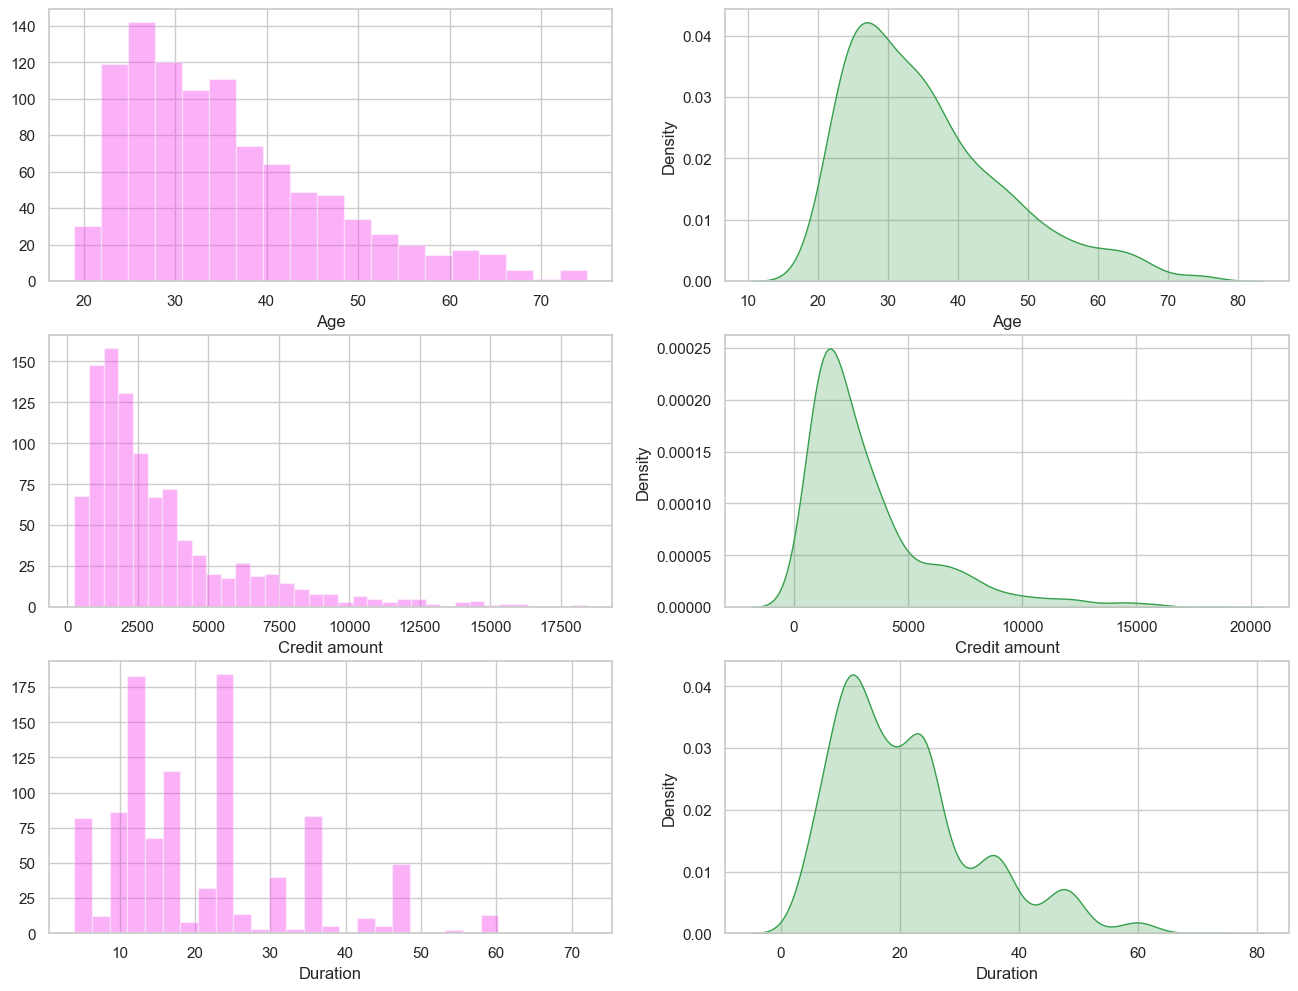

In [87]:
sns.set(font_scale=1,style="whitegrid")
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(16,12))
cat_list=["Age","Credit amount","Duration"]
count=0
for i in range(3):
    sns.distplot(df[cat_list[count]],ax=ax[i][0],kde=False,color="#F43EEC")
    sns.kdeplot(df[cat_list[count]],ax=ax[i][1],shade=True,color="#359F4B")
    count+=1

* "monthly pay" and "credit amount^2"(square) added in data frame.

In [88]:
df["Monthly pay"] = (df["Credit amount"] / df["Duration"])
df["Credit amount^2"] = df["Credit amount"]**2

* 'Age' and 'Duration' columns Classification

In [89]:
df.insert(1,"Cat Age",np.NaN)
df.loc[df["Age"]<25,"Cat Age"]="0-25"
df.loc[((df["Age"]>=25) & (df["Age"]<30)),"Cat Age"]="25-30"
df.loc[((df["Age"]>=30) & (df["Age"]<35)),"Cat Age"]="30-35"
df.loc[((df["Age"]>=35) & (df["Age"]<40)),"Cat Age"]="35-40"
df.loc[((df["Age"]>=40) & (df["Age"]<50)),"Cat Age"]="40-50"
df.loc[((df["Age"]>=50) & (df["Age"]<76)),"Cat Age"]="50-75"

ValueError: cannot insert Cat Age, already exists

In [ ]:
df.insert(9,"Cat Duration",df["Duration"])
for i in df["Cat Duration"]:
    if i<12:
        df["Cat Duration"]=df["Cat Duration"].replace(i,"0-12")
    elif (i>=12) and (i<24):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"12-24")
    elif (i>=24) and (i<36):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"24-36")
    elif (i>=36) and (i<48):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"36-48")
    elif (i>=48) and (i<60):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"48-60")
    elif (i>=60) and (i<=72):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"60-72")

In [62]:
df.insert(4,"Cat Job",df["Job"])
df["Cat Job"]=df["Cat Job"].astype("category")
df["Cat Job"]=df["Cat Job"].replace(0,"unskilled")
df["Cat Job"]=df["Cat Job"].replace(1,"resident")
df["Cat Job"]=df["Cat Job"].replace(2,"skilled")
df["Cat Job"]=df["Cat Job"].replace(3,"highly skilled")

In [63]:
df["Job"]=pd.Categorical(df["Job"],categories=[0,1,2,3],ordered=True)
df["Cat Age"]=pd.Categorical(df["Cat Age"],categories=['0-25','25-30', '30-35','35-40','40-50','50-75'])
df["Cat Duration"]=pd.Categorical(df["Cat Duration"],categories=['0-12','12-24', '24-36','36-48','48-60','60-72'])

In [91]:
df.head()

,Age,Cat Age,Sex,Job,Cat Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Cat Duration,Purpose,Risk,Monthly pay,Credit amount^2,Sex_Encoded
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561,1
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401,0
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216,1
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924,1
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900,1


## Data Visualization

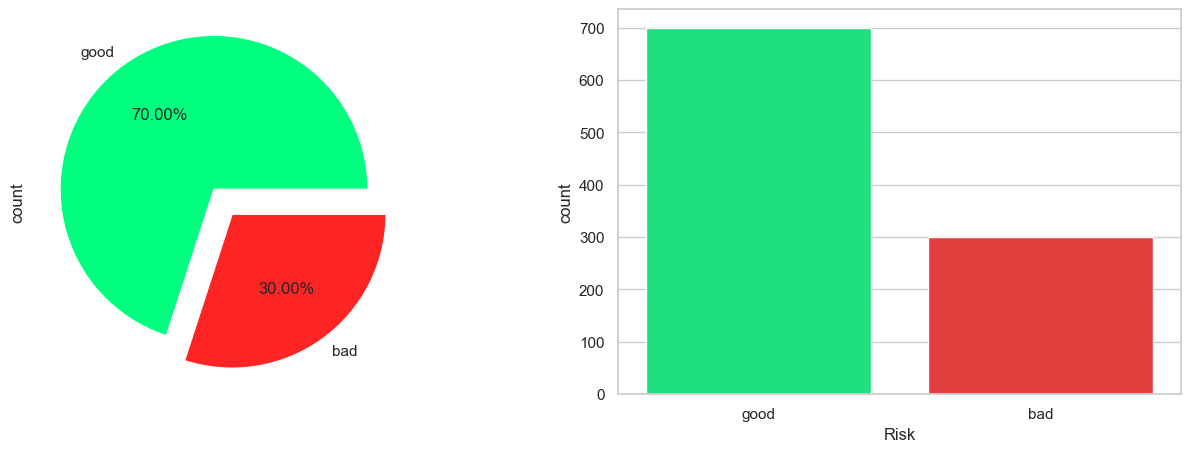

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
df["Risk"] = pd.Categorical(df["Risk"], categories=["good", "bad"])  # Convert the "Risk" column to a categorical variable
df["Risk"].value_counts().plot.pie(autopct="%.2f%%", colors=['#00FF7F', '#FF2424'], explode=(0.1, 0.1), ax=ax[0])
sns.countplot(x=df["Risk"], ax=ax[1], palette=['#00FF7F', '#FF2424'])

plt.show()

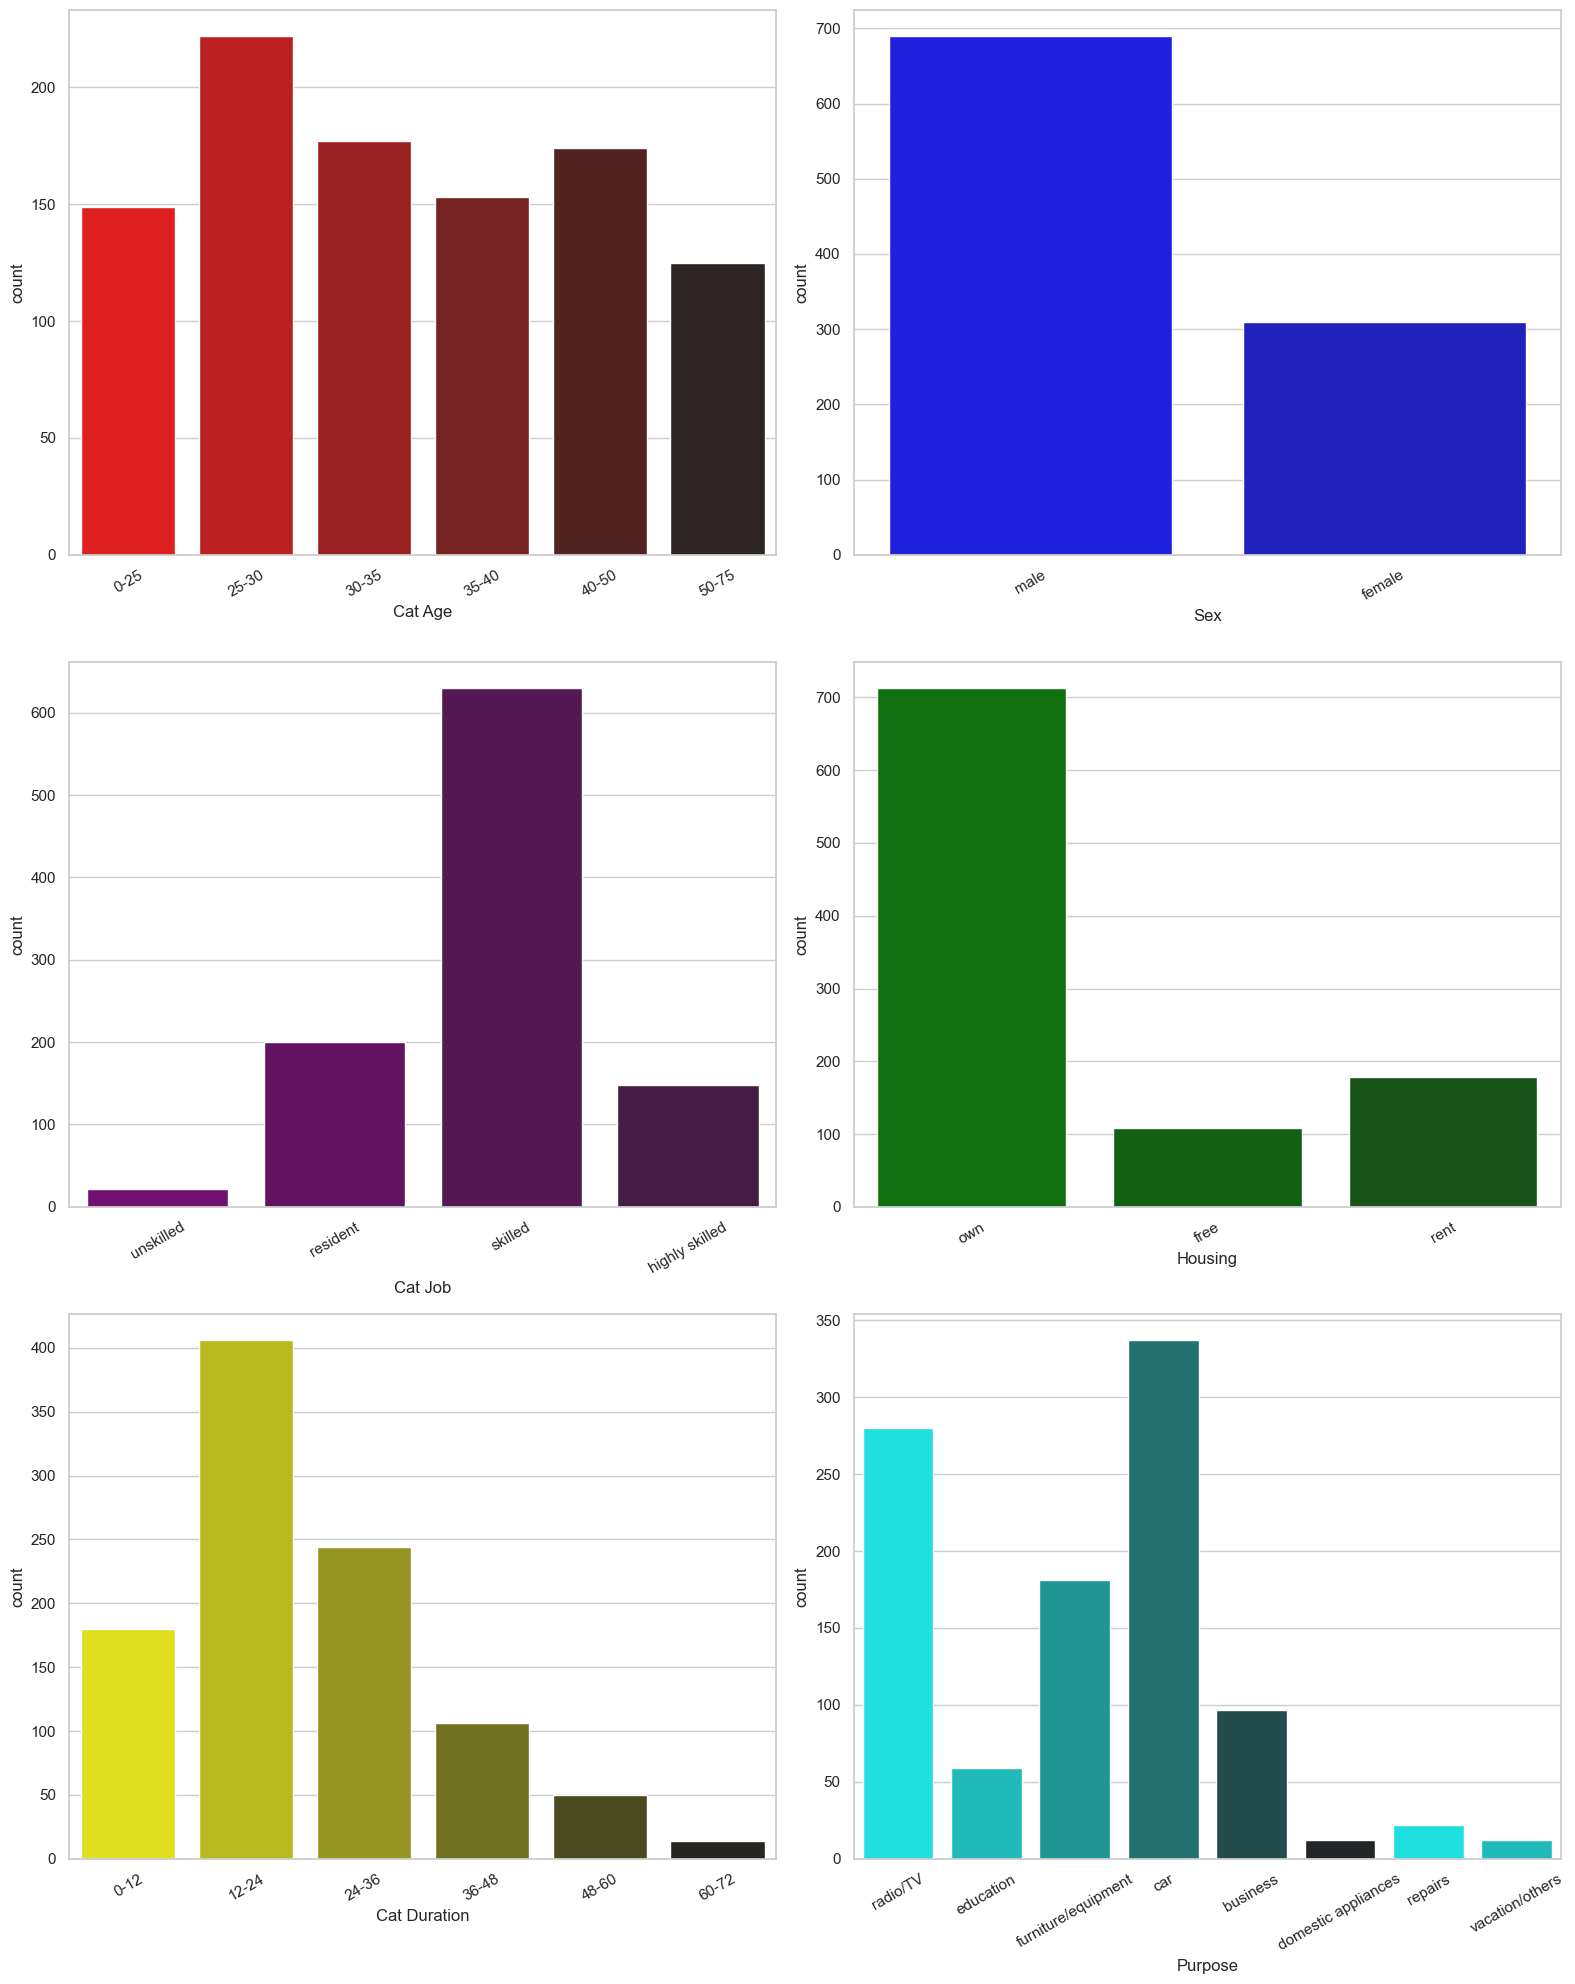

In [93]:
# Display of bar graphs
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 20))
cat_list = ["Cat Age", "Sex", "Cat Job", "Housing", "Cat Duration", "Purpose"]
palette = ["red", "blue", "purple", "green", "yellow", "cyan"]
count = 0

for i in range(3):
    for j in range(2):
        sns.countplot(data=df, x=cat_list[count], ax=ax[i][j], palette=sns.dark_palette(palette[count], reverse=True))
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=30)
        count += 1

plt.tight_layout()
plt.show()

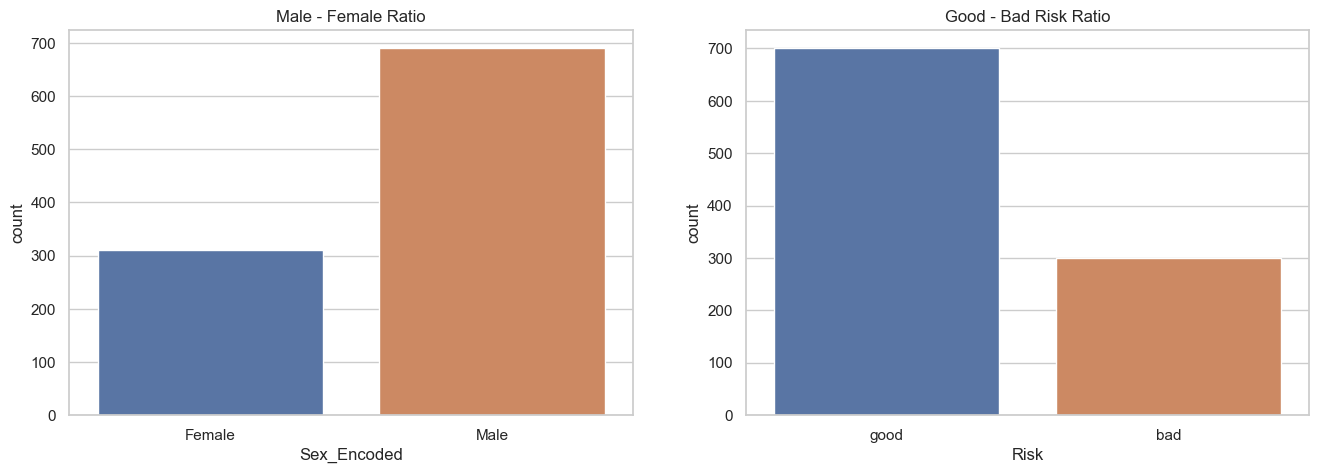

In [94]:
# Encode the 'Sex' column as numeric values
df['Sex_Encoded'] = df['Sex'].map({'female': 0, 'male': 1})

# Display of bar graphs
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(data=df, x='Sex_Encoded', ax=ax[0]).set_title('Male - Female Ratio')
sns.countplot(data=df, x='Risk', ax=ax[1]).set_title('Good - Bad Risk Ratio')

# Customize the x-axis labels on the first graph
ax[0].set_xticklabels(['Female', 'Male'])

plt.show()

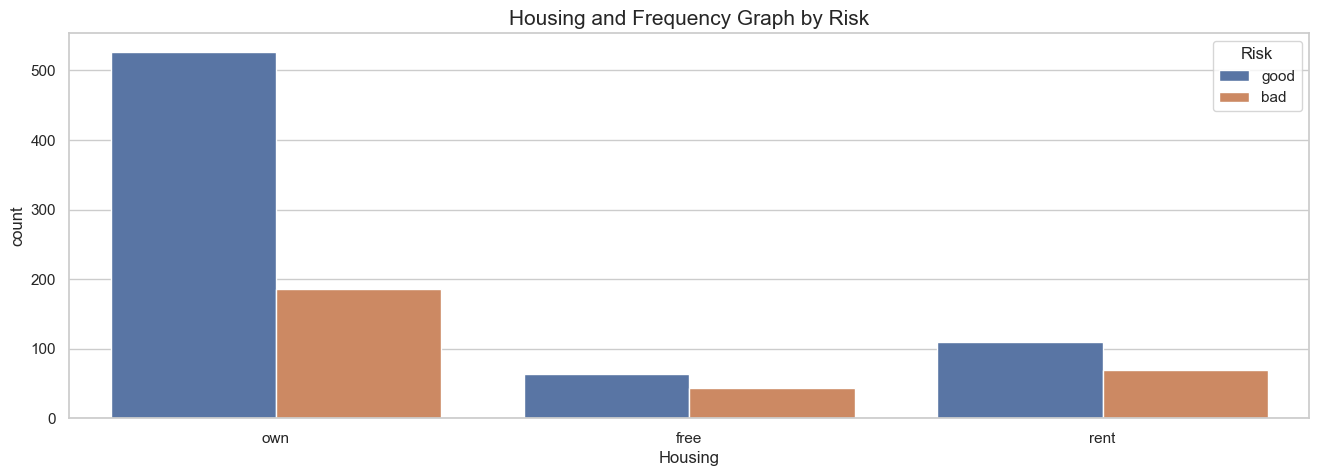

In [95]:
plt.figure(figsize=(16,5))
sns.countplot(x="Housing", hue="Risk", data=df).set_title("Housing and Frequency Graph by Risk", fontsize=15);
plt.show()

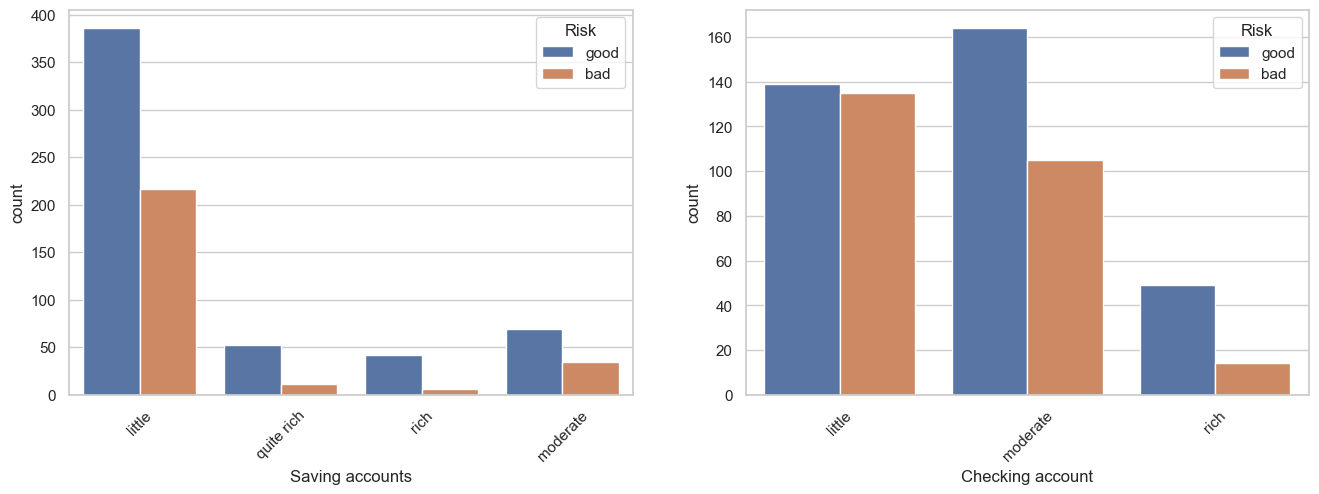

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sns.countplot(x="Saving accounts", hue="Risk", data=df, ax=ax1);
sns.countplot(x="Checking account", hue="Risk", data=df, ax=ax2);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
fig.show()

<Axes: xlabel='Sex', ylabel='Age'>

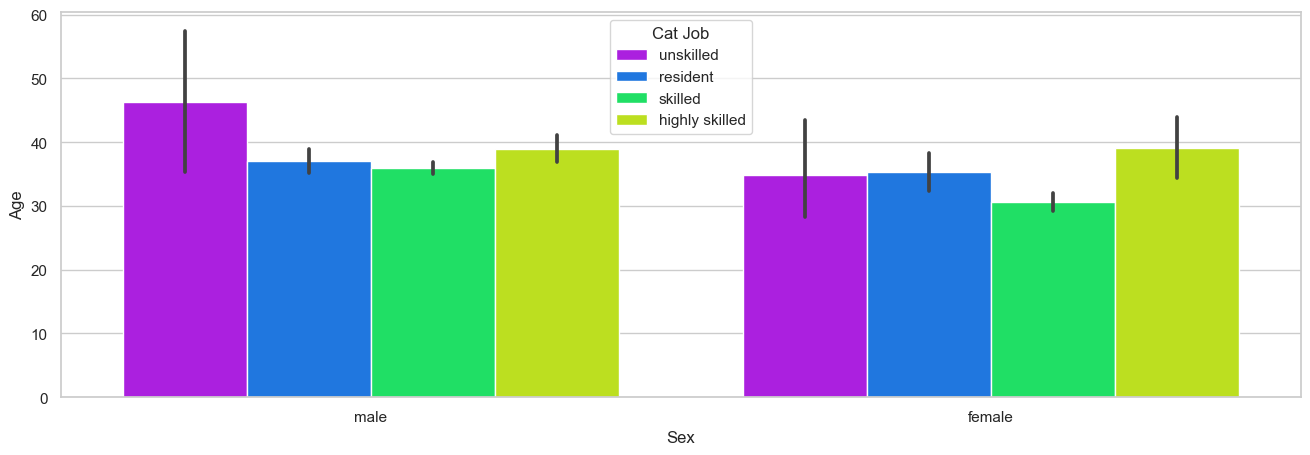

In [97]:
plt.figure(figsize=(16,5))
sns.barplot(data=df,x="Sex",y="Age",hue="Cat Job",palette="hsv_r")

<Axes: xlabel='Cat Age', ylabel='Credit amount'>

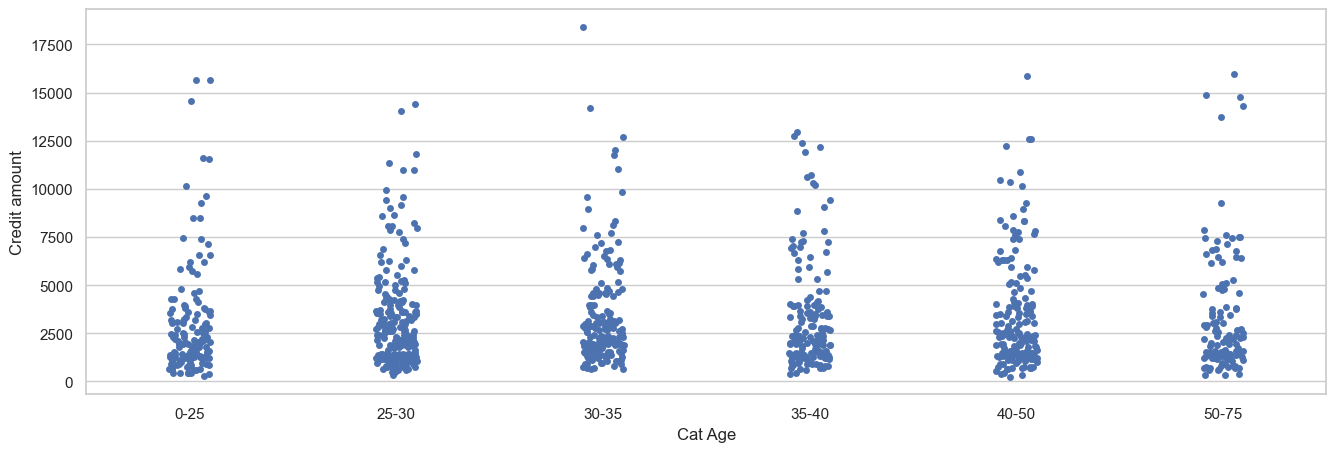

In [98]:
plt.figure(figsize = (16, 5))
sns.stripplot(x = "Cat Age", y = "Credit amount", data = df)

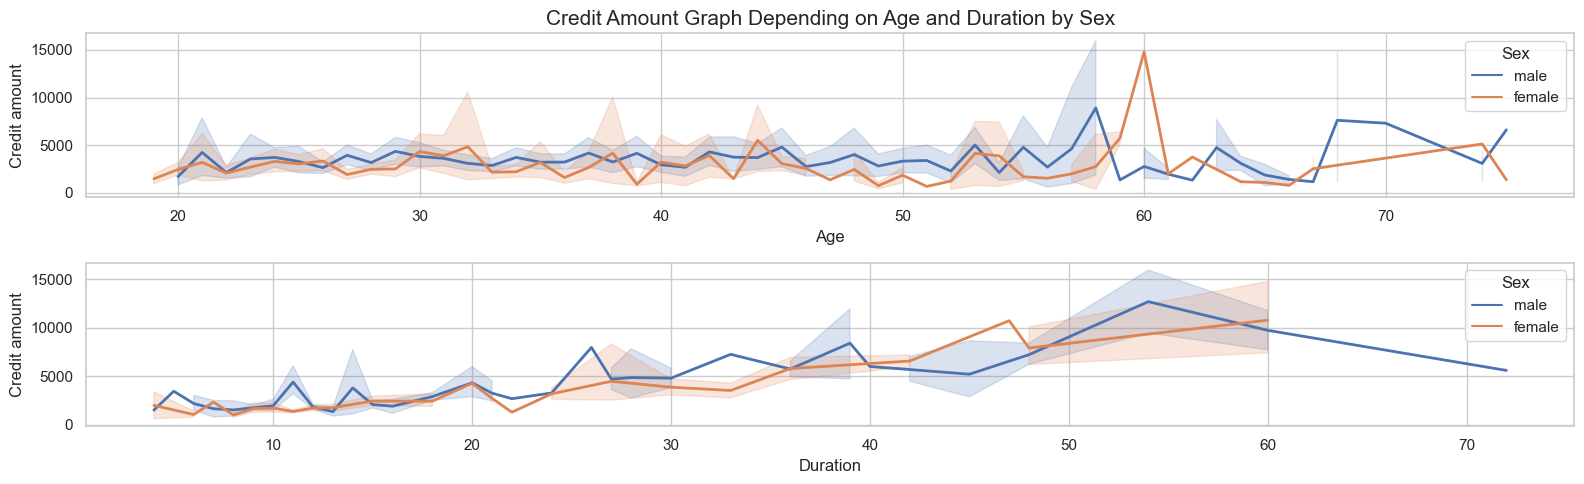

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15)
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1])

plt.tight_layout()  # Automatically adjust subplots

plt.show()

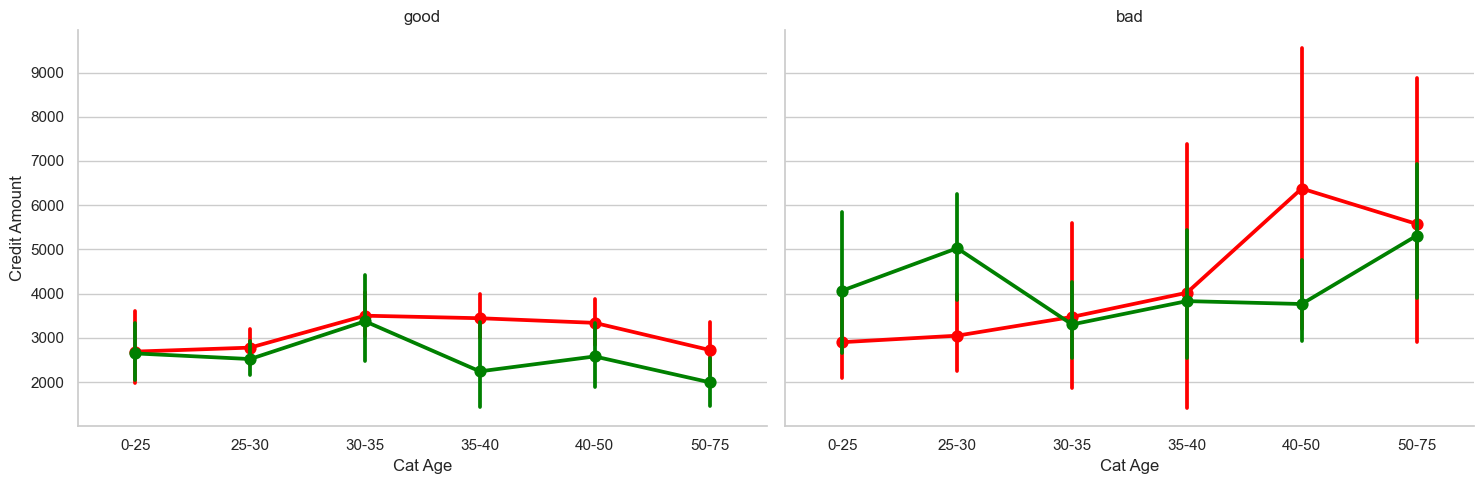

In [111]:
# Style configuration
sns.set(style="whitegrid", palette="colorblind")

# Crear FacetGrid
grid = sns.FacetGrid(data=df, col="Risk", aspect=1.5, height=5)

# Plot points with custom colors
grid.map(sns.pointplot, "Cat Age", "Credit amount", "Sex", palette=["red", "green"])

# Customize titles and labels
grid.set_titles("{col_name}")
grid.set_xlabels("Cat Age")
grid.set_ylabels("Credit Amount")

# Show the graph
plt.show()

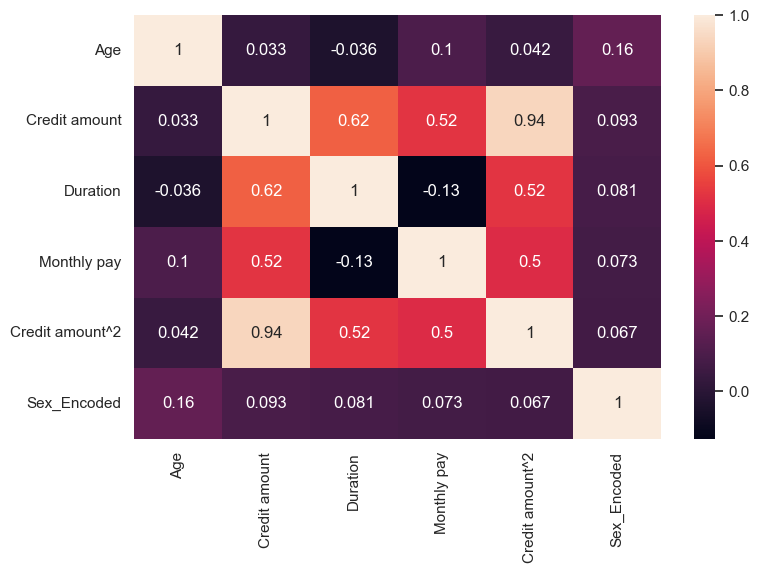

In [113]:
# Filter the numeric columns of the DataFrame
numeric_columns = df.select_dtypes(include=[np.number])

# Create figure and heat map with numeric columns
plt.figure(figsize=(8.5, 5.5))
corr = sns.heatmap(numeric_columns.corr(), xticklabels=numeric_columns.columns, yticklabels=numeric_columns.columns, annot=True)

# Show the graph
plt.show()

## Data Preprocessing

In [114]:
df.head()

,Age,Cat Age,Sex,Job,Cat Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Cat Duration,Purpose,Risk,Monthly pay,Credit amount^2,Sex_Encoded
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561,1
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401,0
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216,1
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924,1
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900,1


In [115]:
df["Age"],df["Duration"],df["Job"]=df["Cat Age"],df["Cat Duration"],df["Cat Job"]
df=df.drop(["Cat Age","Cat Duration","Cat Job"],axis=1)

In [116]:
liste_columns=list(df.columns)
liste_columns.remove("Sex")
liste_columns.remove("Risk")
liste_columns.remove("Credit amount")
liste_columns.remove("Monthly pay")
liste_columns.remove("Credit amount^2")

#### LabelEncoder

In [117]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df["Sex"]=label.fit_transform(df["Sex"])
df["Risk"]=label.fit_transform(df["Risk"])
df=pd.get_dummies(df,columns=liste_columns,prefix=liste_columns)

#### MinMaxScaler

In [118]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df["Credit amount"]=scaler.fit_transform(df[["Credit amount"]])
df["Monthly pay"]=scaler.fit_transform(df[["Monthly pay"]])
df["Credit amount^2"]=scaler.fit_transform(df[["Credit amount^2"]])

In [119]:
df.head()

,Sex,Credit amount,Risk,Monthly pay,Credit amount^2,Age_0-25,Age_25-30,Age_30-35,Age_35-40,Age_40-50,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_Encoded_0,Sex_Encoded_1
0,1,0.050567,1,0.069461,0.003842,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,0,0.313690,0,0.040642,0.104166,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,1,0.101574,1,0.061259,0.012761,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
3,1,0.419941,1,0.066546,0.182872,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
4,1,0.254209,0,0.072749,0.069699,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True


### Building Models

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,classification_report

In [121]:
X=df.drop(["Risk"],axis=1)
Y=df["Risk"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

### Decision Tree Model

In [122]:
from sklearn.tree import DecisionTreeClassifier
cart_model=DecisionTreeClassifier(criterion='gini',max_depth=4,min_samples_leaf=54,min_samples_split=2).fit(X_train,Y_train)

In [123]:
print("Train Accuracy Score : ",accuracy_score(Y_train,cart_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,cart_model.predict(X_test)))

Train Accuracy Score :  0.7571428571428571
Test Accuracy Score :  0.71


In [124]:
print(classification_report(Y_test,cart_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.44      0.47        86
           1       0.78      0.82      0.80       214

    accuracy                           0.71       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.70      0.71      0.70       300



### GradientBoosting Model

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(learning_rate = 0.01,max_depth = 5,min_samples_split = 10,n_estimators = 100).fit(X_train, Y_train)

In [129]:
print("Train Accuracy Score : ",accuracy_score(Y_train,gbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,gbm_model.predict(X_test)))

Train Accuracy Score :  0.8385714285714285
Test Accuracy Score :  0.74


In [130]:
print(classification_report(Y_test,gbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.20      0.30        86
           1       0.75      0.96      0.84       214

    accuracy                           0.74       300
   macro avg       0.70      0.58      0.57       300
weighted avg       0.72      0.74      0.69       300



In [131]:
X_train.shape

(700, 40)

<Axes: >

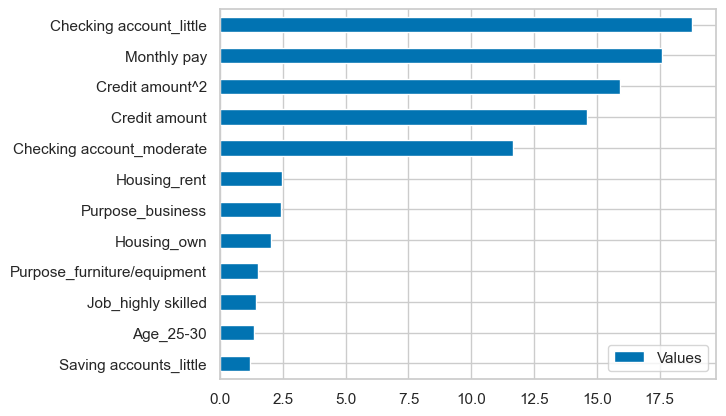

In [132]:
Importance=pd.DataFrame({"Values":gbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

### XGBoost Model

In [143]:
!pip install xgboost

In [135]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.05, max_depth = 5,n_estimators=100,subsample=0.8).fit(X_train,Y_train)

In [136]:
print("Train Accuracy Score : ",accuracy_score(Y_train,xgb_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,xgb_model.predict(X_test)))

Train Accuracy Score :  0.9014285714285715
Test Accuracy Score :  0.7633333333333333


In [137]:
print(classification_report(Y_test,xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.42      0.50        86
           1       0.79      0.90      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.66      0.67       300
weighted avg       0.75      0.76      0.75       300



<Axes: >

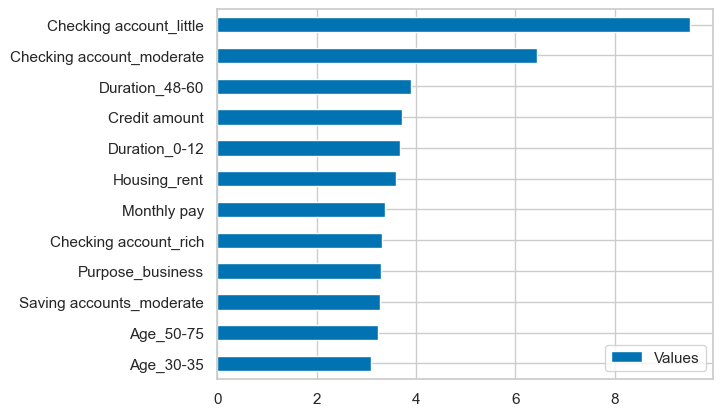

In [138]:
Importance=pd.DataFrame({"Values":xgb_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

### LightGBM Model

In [142]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
lgbm_model=LGBMClassifier(learning_rate=0.02,max_depth=3,min_child_samples=10,n_estimators=200,subsample=0.6).fit(X_train,Y_train)

In [146]:
print("Train Accuracy Score : ",accuracy_score(Y_train,lgbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,lgbm_model.predict(X_test)))

Train Accuracy Score :  0.8157142857142857
Test Accuracy Score :  0.7366666666666667


In [147]:
print(classification_report(Y_test,lgbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.28      0.38        86
           1       0.76      0.92      0.83       214

    accuracy                           0.74       300
   macro avg       0.67      0.60      0.61       300
weighted avg       0.71      0.74      0.70       300



<Axes: >

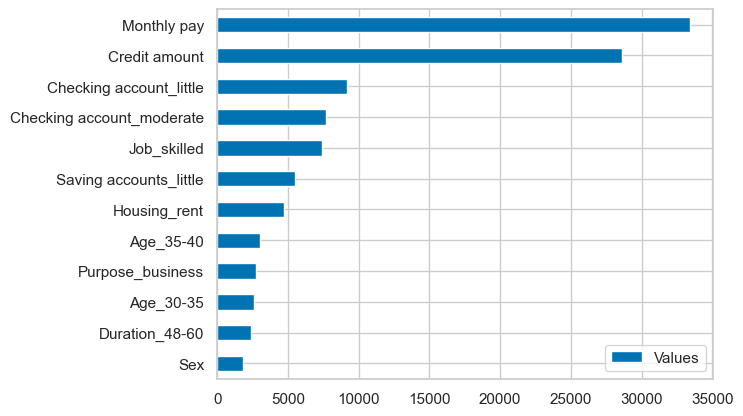

In [148]:
Importance=pd.DataFrame({"Values":lgbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

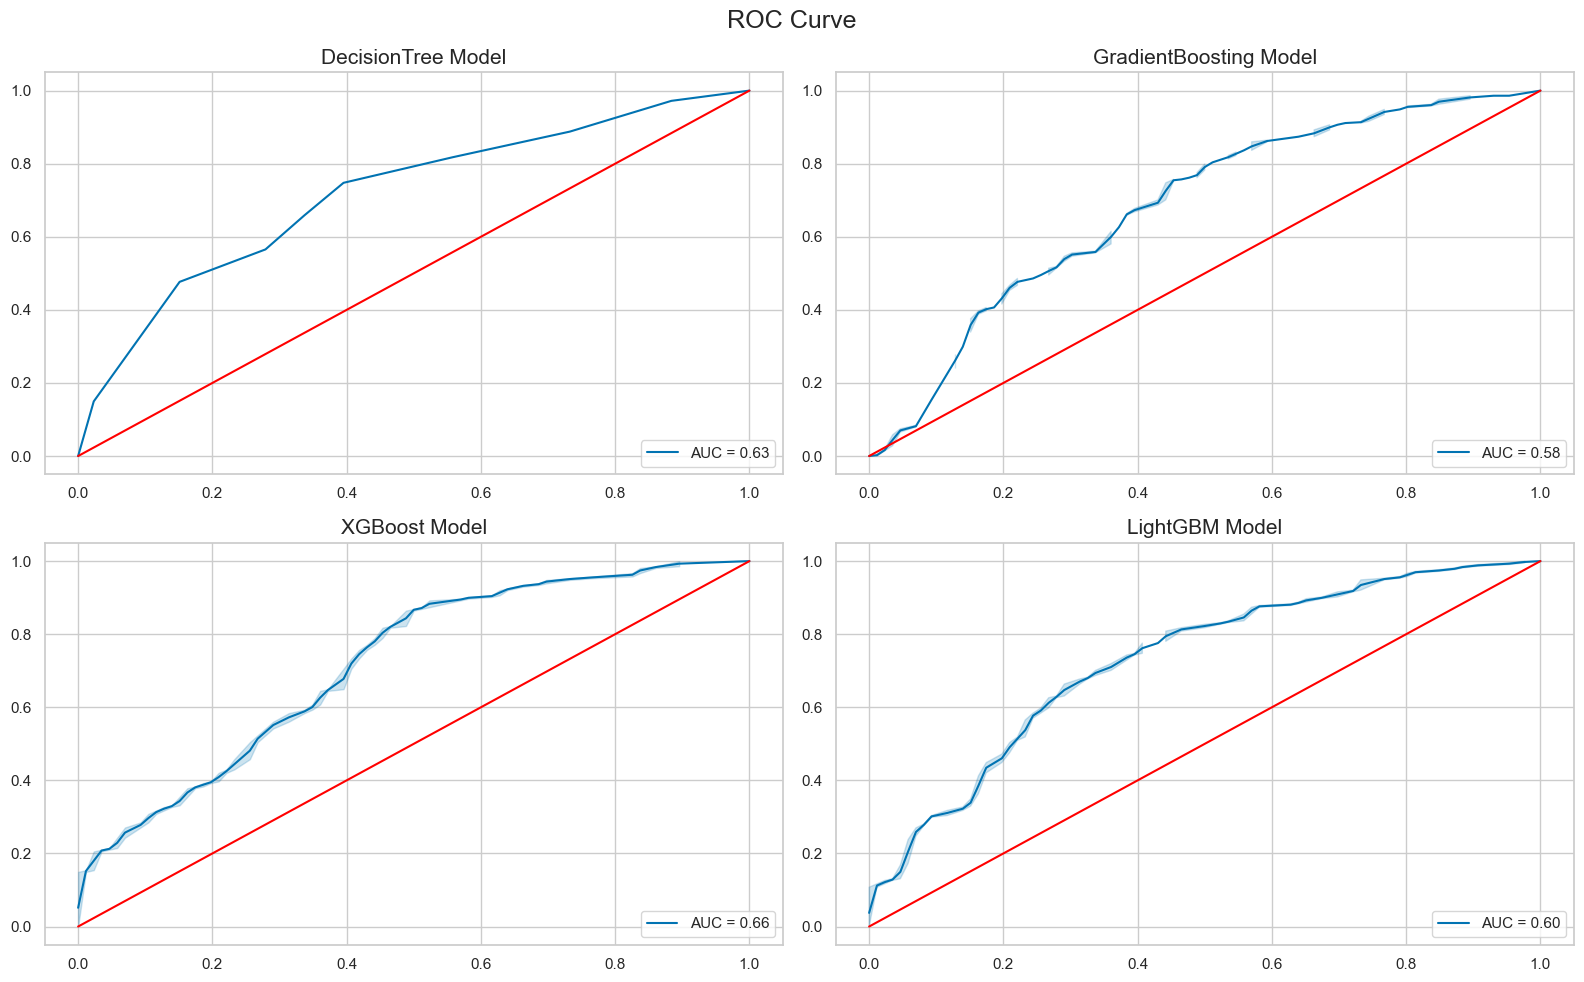

In [152]:
from sklearn.metrics import roc_auc_score, roc_curve

list_model = [cart_model, gbm_model, xgb_model, lgbm_model]
list_model_name = ["DecisionTree Model", "GradientBoosting Model", "XGBoost Model", "LightGBM Model"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for model, model_name, subplot in zip(list_model, list_model_name, ax.flatten()):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    logit_roc_auc = roc_auc_score(Y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

    sns.lineplot(x=fpr, y=tpr, label="AUC = %0.2f" % logit_roc_auc, ax=subplot)
    subplot.plot([0, 1], [0, 1], color="red")
    subplot.legend(loc="lower right")
    subplot.set_title(model_name, fontsize=15)

fig.suptitle("ROC Curve", fontsize=18)
plt.tight_layout()
plt.show()

In [154]:
from sklearn.metrics import accuracy_score

model_data = pd.DataFrame({
    "Model": ["DecisionTree Model", "GradientBoosting Model", "XGBoost Model", "LightGBM Model"],
    "Train Accuracy": [accuracy_score(Y_train, cart_model.predict(X_train)),
                       accuracy_score(Y_train, gbm_model.predict(X_train)),
                       accuracy_score(Y_train, xgb_model.predict(X_train)),
                       accuracy_score(Y_train, lgbm_model.predict(X_train))],
    "Test Accuracy": [accuracy_score(Y_test, cart_model.predict(X_test)),
                      accuracy_score(Y_test, gbm_model.predict(X_test)),
                      accuracy_score(Y_test, xgb_model.predict(X_test)),
                      accuracy_score(Y_test, lgbm_model.predict(X_test))]
})

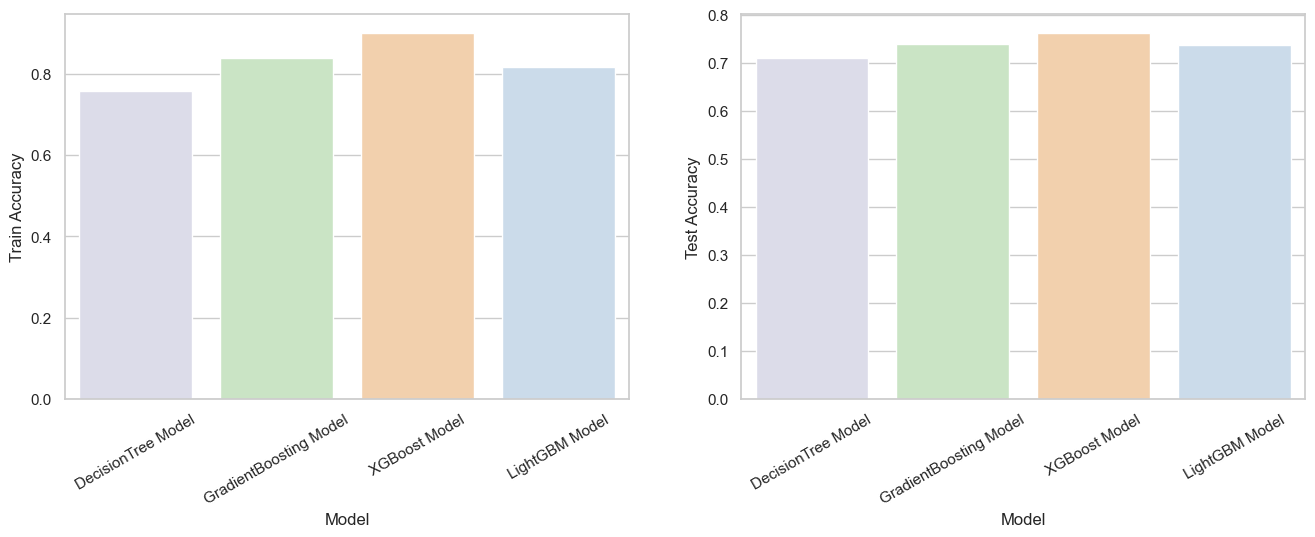

In [155]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
sns.barplot(x="Model",y="Train Accuracy",data=model_data,ax=ax[0],palette="tab20c_r")
sns.barplot(x="Model",y="Test Accuracy",data=model_data,ax=ax[1],palette="tab20c_r")
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=30);

* We saw some important Features at the models results.
* Now, we are creating a Tree image.
* This Tree image shows us to what's going on the behind.

In [156]:
df.head(1)

,Sex,Credit amount,Risk,Monthly pay,Credit amount^2,Age_0-25,Age_25-30,Age_30-35,Age_35-40,Age_40-50,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_Encoded_0,Sex_Encoded_1
0,1,0.050567,1,0.069461,0.003842,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


* Selection 4 features according to importance

In [157]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

variable = ["Risk","Monthly pay","Credit amount","Checking account_little","Checking account_moderate"]

data = df.loc[:,variable]

data.head(2)

,Risk,Monthly pay,Credit amount,Checking account_little,Checking account_moderate
0,1,0.069461,0.050567,True,False
1,0,0.040642,0.313690,False,True


In [158]:
X = data.drop("Risk",axis=1)
y = data["Risk"]

forest = RandomForestClassifier(max_depth = 3, n_estimators=4)
forest.fit(X,y)

RandomForestClassifier(max_depth=3, n_estimators=4)

In [160]:
estimator = forest.estimators_[3]

In [161]:
target_names = ["0: good","1: bad"]

In [162]:
from sklearn.tree import export_graphviz

export_graphviz(estimator,out_file="tree_limited.dot",feature_names=X.columns,
                class_names=target_names,rounded = True, proportion = False, precision = 2, filled = True)

In [163]:
forest_1 = RandomForestClassifier(max_depth = None, n_estimators=4)
forest_1 = forest_1.fit(X,y)
estimator_non = forest_1.estimators_[3]

In [170]:
!pip install graphviz

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


In [180]:
import graphviz

In [181]:
export_graphviz(estimator_non, out_file='tree_nonlimited.dot', feature_names = X.columns,
                class_names = target_names,
                rounded = True, proportion = False, precision = 2, filled = True)

In [ ]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

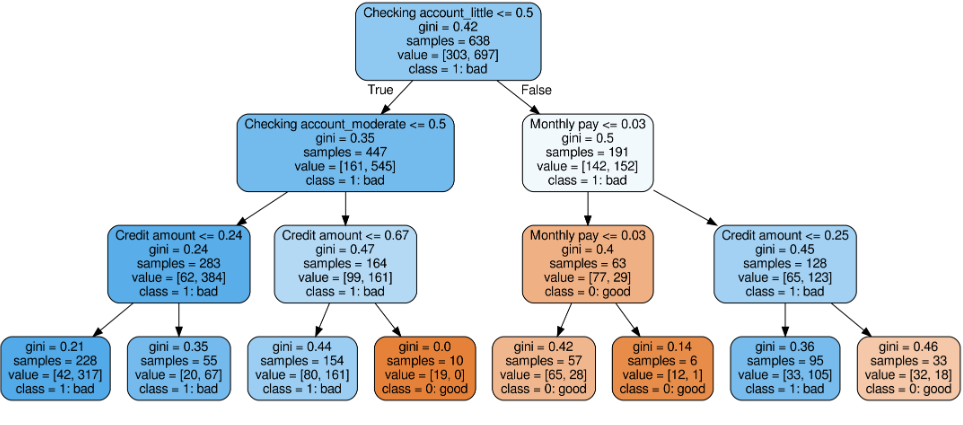

In [184]:
from IPython.display import Image
Image(filename = 'media/tree_limited.png')